# 06_1 Klassifitseerimismudelid - logistiline regressioon_II_VER

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('toofailid/DATA_TEKSTIKOGU_puhastatud.xlsx', engine='openpyxl')
print(data.shape)

(636, 55)


In [3]:
data['Lahendi liik'].value_counts()

õigeksmõistev    350
tauniv           286
Name: Lahendi liik, dtype: int64

In [4]:
# Andmestiku segamine
#from sklearn.utils import shuffle
#data = shuffle(data)
#data = data.reset_index(drop=True)

In [5]:
# Ebavajaliku info  (aeg, pealkiri) eemaldamine
#data.drop(["date"],axis=1,inplace=True)
#data.drop(["title"],axis=1,inplace=True)
#data.drop(["subject"],axis=1,inplace=True)
#data.drop(["link"],axis=1,inplace=True)

In [6]:
#tekst_puhas = data['text_puhas'].to_list()
#tekst_tokenize = data['text_token'].to_list()
#tekst_lemmatize = data['text_lemmatize'].to_list()
#label = data['Lahendi liik'].to_list()

Stoppsõnadena on kasutusel sidesõnad ja sidesõnad koos asesõnadega.

In [7]:
#https://et.wikipedia.org/wiki/Sides%C3%B5na
#https://www.taskutark.ee/m/asesonad/
#sidesõnad
stopsõnad = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']
#sidesõnad ja asesõnad
stopsõnad_uus = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka', 'nii', 'kas',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju', '-']

In [8]:
stop_tekst = []
with open("stop_s.txt", "r", encoding = 'utf8') as file:
    for line in file:
        #print(line.rstrip())
        stop_tekst.append(line.rstrip())

In [9]:
len(stop_tekst)

5001

# Veamaatriks, segadusmaatriks (confusion matrix)

In [10]:
# Veamaatriks (plot the confusion matrix)
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Veamaatriks',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normaliseeritud veamaatriks")
    else:
        print('Normaliseerimata veamaatriks')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('True label/Tõeline märgend')
    plt.xlabel('Predicted label/Prognoositud märgend')

### Logistiline regressioon (Logistic regression)

In [11]:
data.columns

Index(['#', 'title', 'text', 'Kaebuse kuupäev', 'Kaebuse aasta', 'Väljaanne',
       'Väljaande nimi1', 'Lingid', 'Lingid1', 'Dea_digar', 'Kaebuse sisu',
       'Lahendi tulemus1', 'Lahendi tulemus2', 'Lahendi kuupäev',
       'Otsuse sisu', 'Otsuse liik', 'Lahendi liik', 'Väljaande nimi',
       'Väljaande liik', 'Koodeks', '1.2', '1.4', '1.5', '1.6', '2.3', '3.1',
       '3.2', '3.3', '3.5', '3.6', '3.7', '4.1', '4.2', '4.3', '4.4', '4.6',
       '4.7', '4.8', '4.9', '4.10', '4.11', '4.12', '5.1', '5.2', '5.3', '6.1',
       'Koodeksipunkte', 'text_puhas', 'text_token', 'text_lemmatize', 'T1_4',
       'T4_1', 'T4_11', 'T_muu', 'ÕM'],
      dtype='object')

In [66]:
X, y = data['text_token'], data['Lahendi liik'] #sõnestatud tekst
#X, y = data['text_lemmatize'], data['Lahendi liik'] #lemmatiseeritud tekst

In [67]:
X

0      viimastel päevadel valitsenud külmalaine on ri...
1      tuntud ühiskonnategelane räägib et mõni piiran...
2      tahkuna uue elektrituuliku mittepüstitamine lä...
3      viiskümmend aastat tagasi sai tiit leito oma k...
4      tarbija esitas ttja-le kaebuse veskioja 1 oü n...
                             ...                        
631    kolm aastat pärast mait metsamaa surma on teda...
632    neeme järvi ligi kaks aastat tagasi maestro ne...
633    keskkonnainspektsiooni menetlus karepal selja ...
634    eesti kaubandusettevõtted üritavad raha kokku ...
635    võltsjuustude müügiga seostatavat estover-kaub...
Name: text_token, Length: 636, dtype: object

In [68]:
# Andmete tükeldamine treenimisandmestikuks ja testandmestikuks
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [69]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(508,) (128,) (508,) (128,)


In [70]:
X_train

31     kohus arutas põhjalikult kas fekaalidega määri...
427    kliendid leiavad et swedbank peaks võlgu tagas...
610    poliitikud peavad kahetsusväärseks olukorda ku...
499    selle loo ilmumise järel tuleb postimehel tõen...
105    patsient läheb ilukliinikusse suurte ootustega...
                             ...                        
198    kui edaspidi peaks keegi huvi tundma kust ma p...
93     koos kolme sõbrannaga möödunud neljapäeva õhtu...
54     metsatöösturid ja lageraiete vajalikkusest jut...
356    tundub et keskerakonnale on saanud iseenesestm...
489    kohtulugu • eile tartu ringkonnakohtus toimunu...
Name: text_token, Length: 508, dtype: object

In [71]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


skf =  StratifiedKFold(n_splits=10)

c_list = [0.1, 0.2, 0.5, 1, 2, 5, 5.5, 6, 6.5, 7, 10, 20, 50,100]
#c_list = [0.1, 0.5, 1, 2, 5, 5.5, 6]

mean_accuracy = []
tauniv_f1 = []
oigeks_f1 = []
w_avg_f1 = []

for c in c_list:
    print("C väärtus: " + str(c))
    
    metrics_m = []

    f1_t = []
    f1_o = []
    f1_w_avg = []
    for train_index, val_index in skf.split(X_train, y_train):
        X_treen, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_treen, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        

        pipe = Pipeline([('vect', TfidfVectorizer(
                                                  min_df = 3, 
                                                  stop_words = stop_tekst, 
                                                  max_df=0.85, 
                                                  #ngram_range=(1,2),
                                                  smooth_idf=True,
                                                  use_idf=True
                                                 )
                                                 ),
                       ('model', LogisticRegression(C = c))])

        # Mudeli sobitamine
        model = pipe.fit(X_treen, y_treen)

        # Prognoosimine
        y_pred = model.predict(X_val)
      
        metrics_m.append(accuracy_score(y_val, y_pred))
        
        tulemus = {}
        
        tulemus[c] = classification_report(y_val, y_pred, digits = 3, output_dict=True)
        print(tulemus[c]['tauniv']['f1-score'])
        f1_t.append(tulemus[c]['tauniv']['f1-score'])
        f1_o.append(tulemus[c]['õigeksmõistev']['f1-score'])
        f1_w_avg.append(tulemus[c]['weighted avg']['f1-score'])
    

        print(classification_report(y_val, y_pred, digits = 3))
        
        print('Confusion Matrix:',confusion_matrix(y_val, y_pred))
    
    #tauniv f1 skoor keskmiselt
    f1_t = np.array(f1_t)
    print('Keskmine tauniv f1: ', np.mean(f1_t, axis=0))
    tauniv_f1.append(np.mean(f1_t, axis=0))
    
    #õigeksmõistev f1 skoor keskmiselt
    f1_o = np.array(f1_o)
    print('Keskmine tauniv f1: ', np.mean(f1_o, axis=0))
    oigeks_f1.append(np.mean(f1_o, axis=0))
    
    #weighted avg f1 skoor keskmiselt
    f1_w_avg = np.array(f1_w_avg)
    print('Keskmine f1_w_avg: ', np.mean(f1_w_avg, axis=0))
    w_avg_f1.append(np.mean(f1_w_avg, axis=0))
    
    metrics_m = np.array(metrics_m)
    print('Mean accuracy: ', np.mean(metrics_m, axis=0))
    mean_accuracy.append(np.mean(metrics_m, axis=0))
    print('Std for accuracy: ', np.std(metrics_m, axis=0))

C väärtus: 0.1


C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.0
               precision    recall  f1-score   support

       tauniv      0.000     0.000     0.000        23
õigeksmõistev      0.549     1.000     0.709        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.275     0.500     0.354        51
 weighted avg      0.301     0.549     0.389        51

Confusion Matrix: [[ 0 23]
 [ 0 28]]
0.0
               precision    recall  f1-score   support

       tauniv      0.000     0.000     0.000        23
õigeksmõistev      0.549     1.000     0.709        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.275     0.500     0.354        51
 weighted avg      0.301     0.549     0.389        51

Confusion Matrix: [[ 0 23]
 [ 0 28]]
0.0
               precision    recall  f1-score   support

       tauniv      0.000     0.000     0.000        23
õigeksmõistev      0.549     1.000     0.709        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.275  

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.0
               precision    recall  f1-score   support

       tauniv      0.000     0.000     0.000        23
õigeksmõistev      0.549     1.000     0.709        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.275     0.500     0.354        51
 weighted avg      0.301     0.549     0.389        51

Confusion Matrix: [[ 0 23]
 [ 0 28]]
0.0
               precision    recall  f1-score   support

       tauniv      0.000     0.000     0.000        23
õigeksmõistev      0.549     1.000     0.709        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.275     0.500     0.354        51
 weighted avg      0.301     0.549     0.389        51

Confusion Matrix: [[ 0 23]
 [ 0 28]]
0.0
               precision    recall  f1-score   support

       tauniv      0.000     0.000     0.000        23
õigeksmõistev      0.549     1.000     0.709        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.275  

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.2857142857142857
               precision    recall  f1-score   support

       tauniv      0.800     0.174     0.286        23
õigeksmõistev      0.587     0.964     0.730        28

    micro avg      0.608     0.608     0.608        51
    macro avg      0.693     0.569     0.508        51
 weighted avg      0.683     0.608     0.529        51

Confusion Matrix: [[ 4 19]
 [ 1 27]]
0.3333333333333333
               precision    recall  f1-score   support

       tauniv      0.714     0.217     0.333        23
õigeksmõistev      0.591     0.929     0.722        28

    micro avg      0.608     0.608     0.608        51
    macro avg      0.653     0.573     0.528        51
 weighted avg      0.647     0.608     0.547        51

Confusion Matrix: [[ 5 18]
 [ 2 26]]
0.27586206896551724
               precision    recall  f1-score   support

       tauniv      0.667     0.174     0.276        23
õigeksmõistev      0.578     0.929     0.712        28

    micro avg      0.588     0.588 

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.3448275862068966
               precision    recall  f1-score   support

       tauniv      0.833     0.217     0.345        23
õigeksmõistev      0.600     0.964     0.740        28

    micro avg      0.627     0.627     0.627        51
    macro avg      0.717     0.591     0.542        51
 weighted avg      0.705     0.627     0.562        51

Confusion Matrix: [[ 5 18]
 [ 1 27]]
0.3333333333333333
               precision    recall  f1-score   support

       tauniv      0.714     0.217     0.333        23
õigeksmõistev      0.591     0.929     0.722        28

    micro avg      0.608     0.608     0.608        51
    macro avg      0.653     0.573     0.528        51
 weighted avg      0.647     0.608     0.547        51

Confusion Matrix: [[ 5 18]
 [ 2 26]]
0.4
               precision    recall  f1-score   support

       tauniv      0.583     0.304     0.400        23
õigeksmõistev      0.590     0.821     0.687        28

    micro avg      0.588     0.588     0.588       

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.4
               precision    recall  f1-score   support

       tauniv      0.857     0.261     0.400        23
õigeksmõistev      0.614     0.964     0.750        28

    micro avg      0.647     0.647     0.647        51
    macro avg      0.735     0.613     0.575        51
 weighted avg      0.723     0.647     0.592        51

Confusion Matrix: [[ 6 17]
 [ 1 27]]
0.4571428571428571
               precision    recall  f1-score   support

       tauniv      0.667     0.348     0.457        23
õigeksmõistev      0.615     0.857     0.716        28

    micro avg      0.627     0.627     0.627        51
    macro avg      0.641     0.602     0.587        51
 weighted avg      0.639     0.627     0.599        51

Confusion Matrix: [[ 8 15]
 [ 4 24]]
0.3888888888888889
               precision    recall  f1-score   support

       tauniv      0.538     0.304     0.389        23
õigeksmõistev      0.579     0.786     0.667        28

    micro avg      0.569     0.569     0.569       

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.37500000000000006
               precision    recall  f1-score   support

       tauniv      0.667     0.261     0.375        23
õigeksmõistev      0.595     0.893     0.714        28

    micro avg      0.608     0.608     0.608        51
    macro avg      0.631     0.577     0.545        51
 weighted avg      0.627     0.608     0.561        51

Confusion Matrix: [[ 6 17]
 [ 3 25]]
0.41025641025641024
               precision    recall  f1-score   support

       tauniv      0.500     0.348     0.410        23
õigeksmõistev      0.571     0.714     0.635        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.536     0.531     0.523        51
 weighted avg      0.539     0.549     0.534        51

Confusion Matrix: [[ 8 15]
 [ 8 20]]
0.3684210526315789
               precision    recall  f1-score   support

       tauniv      0.467     0.304     0.368        23
õigeksmõistev      0.556     0.714     0.625        28

    micro avg      0.529     0.529

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.37500000000000006
               precision    recall  f1-score   support

       tauniv      0.667     0.261     0.375        23
õigeksmõistev      0.595     0.893     0.714        28

    micro avg      0.608     0.608     0.608        51
    macro avg      0.631     0.577     0.545        51
 weighted avg      0.627     0.608     0.561        51

Confusion Matrix: [[ 6 17]
 [ 3 25]]
0.41025641025641024
               precision    recall  f1-score   support

       tauniv      0.500     0.348     0.410        23
õigeksmõistev      0.571     0.714     0.635        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.536     0.531     0.523        51
 weighted avg      0.539     0.549     0.534        51

Confusion Matrix: [[ 8 15]
 [ 8 20]]
0.3684210526315789
               precision    recall  f1-score   support

       tauniv      0.467     0.304     0.368        23
õigeksmõistev      0.556     0.714     0.625        28

    micro avg      0.529     0.529

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.37500000000000006
               precision    recall  f1-score   support

       tauniv      0.667     0.261     0.375        23
õigeksmõistev      0.595     0.893     0.714        28

    micro avg      0.608     0.608     0.608        51
    macro avg      0.631     0.577     0.545        51
 weighted avg      0.627     0.608     0.561        51

Confusion Matrix: [[ 6 17]
 [ 3 25]]
0.41025641025641024
               precision    recall  f1-score   support

       tauniv      0.500     0.348     0.410        23
õigeksmõistev      0.571     0.714     0.635        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.536     0.531     0.523        51
 weighted avg      0.539     0.549     0.534        51

Confusion Matrix: [[ 8 15]
 [ 8 20]]
0.3684210526315789
               precision    recall  f1-score   support

       tauniv      0.467     0.304     0.368        23
õigeksmõistev      0.556     0.714     0.625        28

    micro avg      0.529     0.529

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.37500000000000006
               precision    recall  f1-score   support

       tauniv      0.667     0.261     0.375        23
õigeksmõistev      0.595     0.893     0.714        28

    micro avg      0.608     0.608     0.608        51
    macro avg      0.631     0.577     0.545        51
 weighted avg      0.627     0.608     0.561        51

Confusion Matrix: [[ 6 17]
 [ 3 25]]
0.41025641025641024
               precision    recall  f1-score   support

       tauniv      0.500     0.348     0.410        23
õigeksmõistev      0.571     0.714     0.635        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.536     0.531     0.523        51
 weighted avg      0.539     0.549     0.534        51

Confusion Matrix: [[ 8 15]
 [ 8 20]]
0.3684210526315789
               precision    recall  f1-score   support

       tauniv      0.467     0.304     0.368        23
õigeksmõistev      0.556     0.714     0.625        28

    micro avg      0.529     0.529

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.37500000000000006
               precision    recall  f1-score   support

       tauniv      0.667     0.261     0.375        23
õigeksmõistev      0.595     0.893     0.714        28

    micro avg      0.608     0.608     0.608        51
    macro avg      0.631     0.577     0.545        51
 weighted avg      0.627     0.608     0.561        51

Confusion Matrix: [[ 6 17]
 [ 3 25]]
0.41025641025641024
               precision    recall  f1-score   support

       tauniv      0.500     0.348     0.410        23
õigeksmõistev      0.571     0.714     0.635        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.536     0.531     0.523        51
 weighted avg      0.539     0.549     0.534        51

Confusion Matrix: [[ 8 15]
 [ 8 20]]
0.3243243243243243
               precision    recall  f1-score   support

       tauniv      0.429     0.261     0.324        23
õigeksmõistev      0.541     0.714     0.615        28

    micro avg      0.510     0.510

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.37500000000000006
               precision    recall  f1-score   support

       tauniv      0.667     0.261     0.375        23
õigeksmõistev      0.595     0.893     0.714        28

    micro avg      0.608     0.608     0.608        51
    macro avg      0.631     0.577     0.545        51
 weighted avg      0.627     0.608     0.561        51

Confusion Matrix: [[ 6 17]
 [ 3 25]]
0.41025641025641024
               precision    recall  f1-score   support

       tauniv      0.500     0.348     0.410        23
õigeksmõistev      0.571     0.714     0.635        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.536     0.531     0.523        51
 weighted avg      0.539     0.549     0.534        51

Confusion Matrix: [[ 8 15]
 [ 8 20]]
0.31578947368421056
               precision    recall  f1-score   support

       tauniv      0.400     0.261     0.316        23
õigeksmõistev      0.528     0.679     0.594        28

    micro avg      0.490     0.49

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.5142857142857143
               precision    recall  f1-score   support

       tauniv      0.750     0.391     0.514        23
õigeksmõistev      0.641     0.893     0.746        28

    micro avg      0.667     0.667     0.667        51
    macro avg      0.696     0.642     0.630        51
 weighted avg      0.690     0.667     0.642        51

Confusion Matrix: [[ 9 14]
 [ 3 25]]
0.41025641025641024
               precision    recall  f1-score   support

       tauniv      0.500     0.348     0.410        23
õigeksmõistev      0.571     0.714     0.635        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.536     0.531     0.523        51
 weighted avg      0.539     0.549     0.534        51

Confusion Matrix: [[ 8 15]
 [ 8 20]]
0.31578947368421056
               precision    recall  f1-score   support

       tauniv      0.400     0.261     0.316        23
õigeksmõistev      0.528     0.679     0.594        28

    micro avg      0.490     0.490

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.5142857142857143
               precision    recall  f1-score   support

       tauniv      0.750     0.391     0.514        23
õigeksmõistev      0.641     0.893     0.746        28

    micro avg      0.667     0.667     0.667        51
    macro avg      0.696     0.642     0.630        51
 weighted avg      0.690     0.667     0.642        51

Confusion Matrix: [[ 9 14]
 [ 3 25]]
0.41025641025641024
               precision    recall  f1-score   support

       tauniv      0.500     0.348     0.410        23
õigeksmõistev      0.571     0.714     0.635        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.536     0.531     0.523        51
 weighted avg      0.539     0.549     0.534        51

Confusion Matrix: [[ 8 15]
 [ 8 20]]
0.30769230769230765
               precision    recall  f1-score   support

       tauniv      0.375     0.261     0.308        23
õigeksmõistev      0.514     0.643     0.571        28

    micro avg      0.471     0.471

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

0.5142857142857143
               precision    recall  f1-score   support

       tauniv      0.750     0.391     0.514        23
õigeksmõistev      0.641     0.893     0.746        28

    micro avg      0.667     0.667     0.667        51
    macro avg      0.696     0.642     0.630        51
 weighted avg      0.690     0.667     0.642        51

Confusion Matrix: [[ 9 14]
 [ 3 25]]
0.41025641025641024
               precision    recall  f1-score   support

       tauniv      0.500     0.348     0.410        23
õigeksmõistev      0.571     0.714     0.635        28

    micro avg      0.549     0.549     0.549        51
    macro avg      0.536     0.531     0.523        51
 weighted avg      0.539     0.549     0.534        51

Confusion Matrix: [[ 8 15]
 [ 8 20]]
0.30769230769230765
               precision    recall  f1-score   support

       tauniv      0.375     0.261     0.308        23
õigeksmõistev      0.514     0.643     0.571        28

    micro avg      0.471     0.471

In [72]:
d = {'c-väärtus': c_list, 'tauniv f1': tauniv_f1, 'õigeksmõistev f1': oigeks_f1,'weighted avg f1': w_avg_f1}
df = pd.DataFrame(data=d)

In [73]:
df

,c-väärtus,tauniv f1,õigeksmõistev f1,weighted avg f1
0,0.1,0.000000,0.710678,0.391753
1,0.2,0.049667,0.714610,0.415986
2,0.5,0.290476,0.725312,0.530131
3,1.0,0.419529,0.724806,0.587727
4,2.0,0.474067,0.715222,0.606873
5,5.0,0.491075,0.689772,0.600447
6,5.5,0.491075,0.689772,0.600447
7,6.0,0.493166,0.688810,0.600836
8,6.5,0.491837,0.686511,0.598964
9,7.0,0.487427,0.685549,0.596447


In [74]:
for i in range(len(c_list)):
    print(str(c_list[i]) + '\t ' + str(mean_accuracy[i]))

0.1	 0.5512156862745099
0.2	 0.5611764705882353
0.5	 0.6044313725490196
1	 0.6279607843137255
2	 0.6319607843137255
5	 0.6163529411764705
5.5	 0.6163529411764705
6	 0.6163921568627451
6.5	 0.6143921568627451
7	 0.6124313725490196
10	 0.5966666666666666
20	 0.6045098039215686
50	 0.6005490196078431
100	 0.5965882352941178


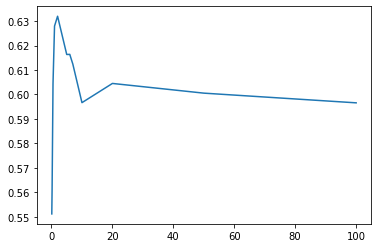

In [75]:
plt.plot(c_list, mean_accuracy)

C:\Users\annel\anaconda3\envs\AL_keskkond\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aidu', 'bai', 'emb', 'emba', 'emma', 'emmaks', 'emmal', 'emmale', 'emmalt', 'emmas', 'emmasse', 'emmast', 'ha', 'he', 'heldeke', 'hii', 'hip', 'hoh', 'hä', 'hää', 'ih', 'ii', 'jaa', 'killa', 'kimps', 'kips', 'kirr', 'kirra', 'klu', 'kluu', 'kohva', 'kolla', 'kripa', 'krips', 'ksti', 'kõlk', 'kõlla', 'kõlladi', 'kõrra', 'köki', 'kأ', 'liiri', 'lika', 'likat', 'lutu', 'luutu', 'lõka', 'lõkat', 'lõõri', 'lأö', 'mull', 'mäta', 'möki', 'müh', 'müt', 'müta', 'mأ', 'mأö', 'ne', 'nämm', 'nõka', 'nõksat', 'nühkat', 'piiri', 'piu', 'ps', 'pup', 'pääri', 'põrra', 'pأö', 'raidu', 'rd', 'rips', 'rأ', 'sahka', 'sahkadi', 'setme', 'setmed', 'setmega', 'setmeid', 'setmeiks', 'setmeil', 'setmeile', 'setmeilt', 'setmeis', 'setmeisse', 'setmeist', 'setmeks', 'setmel', 'setmele', 'setmelt',

Normaliseerimata veamaatriks
Logistilise regressiooni mudeli ennustustäpsus: 60.94%
               precision    recall  f1-score   support

       tauniv      0.611     0.379     0.468        58
õigeksmõistev      0.609     0.800     0.691        70

    micro avg      0.609     0.609     0.609       128
    macro avg      0.610     0.590     0.580       128
 weighted avg      0.610     0.609     0.590       128



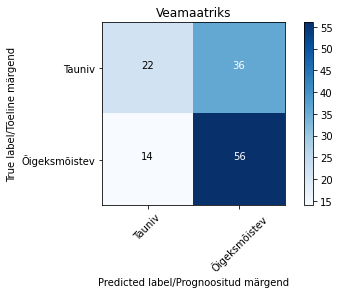

In [76]:
pipe_valitud = Pipeline([('vect', TfidfVectorizer(
                                          min_df = 3, 
                                          stop_words = stop_tekst, 
                                          max_df=0.85, 
                                          #ngram_range=(1,2),
                                          smooth_idf=True,
                                          use_idf=True
                                         )
                                         ),
                       ('model_valitud', LogisticRegression(C = 50))])

# Mudeli sobitamine
model_valitud = pipe_valitud.fit(X_train, y_train)

# Prognoosimine
y_pred_valitud = model_valitud.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred_valitud)
plot_confusion_matrix(cm, classes=['Tauniv', 'Õigeksmõistev'])
print("Logistilise regressiooni mudeli ennustustäpsus: {}%".format(round(accuracy_score(y_test, y_pred_valitud)*100,2)))
print(classification_report(y_test, y_pred_valitud, digits = 3))

Logistilise regressiooni mudeli ennustustäpsus: 59.38%
Normaliseerimata veamaatriks
               precision    recall  f1-score   support

       tauniv      0.650     0.224     0.333        58
õigeksmõistev      0.583     0.900     0.708        70

    micro avg      0.594     0.594     0.594       128
    macro avg      0.617     0.562     0.521       128
 weighted avg      0.614     0.594     0.538       128



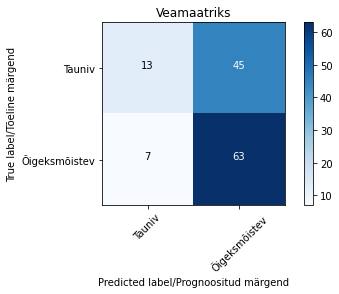

In [77]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
                 ('tfidf', TfidfVectorizer()),
                 ('model', LogisticRegression())])

# Mudeli sobitamine
model_ilma = pipe.fit(X_train, y_train)

# Prognoosimine
prediction = model_ilma.predict(X_test)
print("Logistilise regressiooni mudeli ennustustäpsus: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Tauniv', 'Õigeksmõistev'])
print(classification_report(y_test, prediction, digits = 3))